In [2]:
%matplotlib notebook
import math
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.datasets import make_classification
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

### Settings section
Here you can change parameters to see how the affect performance


In [15]:
feature_count=2
debug = False
alpha = .1
iteration_count = 10000
samples =259

### Parameter set section


In [16]:
test_data=make_classification(n_samples=samples,
                              n_features=feature_count, n_redundant=0, n_informative=2, n_clusters_per_class=1,
                              random_state=10)
test_thetas = np.arange(1,feature_count+1).reshape(1,-1)
xes=test_data[0]
yes=test_data[1].reshape(-1,1)
X_train,X_test,y_train,y_test = train_test_split(xes,yes,random_state=10)

### Start section

In [20]:
def start(X_train,y_train,X_test,y_test,thetas,alpha,iterations,debug=False):
    np.set_printoptions(suppress=True)
    if debug:
        debugInfo()
    else:
        initial_thetas=thetas
        thetas = gradient_descent(X_train,y_train,thetas,alpha,iterations)
        print("Costs\nBefore Training\t{}\nAfter Training\t{}".format(cost_function(X_train,y_train,initial_thetas),
                                                                      cost_function(X_train,y_train,thetas)))
        print("Average error in prediction\nBefore Training\t{}\nAfter Training\t{}".format(avg_error_prediction(X_test,y_test,initial_thetas),
                                                                                            avg_error_prediction(X_test,y_test,thetas)))
        print("Visualisation:\n")
        if(X_train.shape[1]==2):
            visualize(X_train,y_train,initial_thetas,alpha,"Before training")
            visualize(X_train,y_train,thetas,alpha,"After training")
        if(X_train.shape[1]!=2):
            print("Features != 2. No implementation for {} dimensions".format(X_train.shape[1]-1))

Costs
Before Training	[ 160.53149657]
After Training	[ 20.71761614]
Average error in prediction
Before Training	[ 3.29956389]
After Training	[ 0.00090717]
Visualisation:



<IPython.core.display.Javascript object>


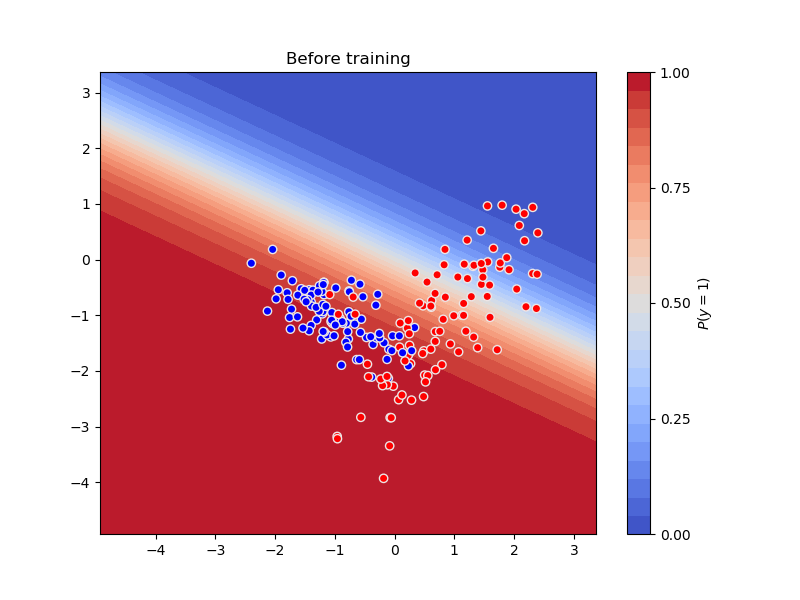

<IPython.core.display.Javascript object>


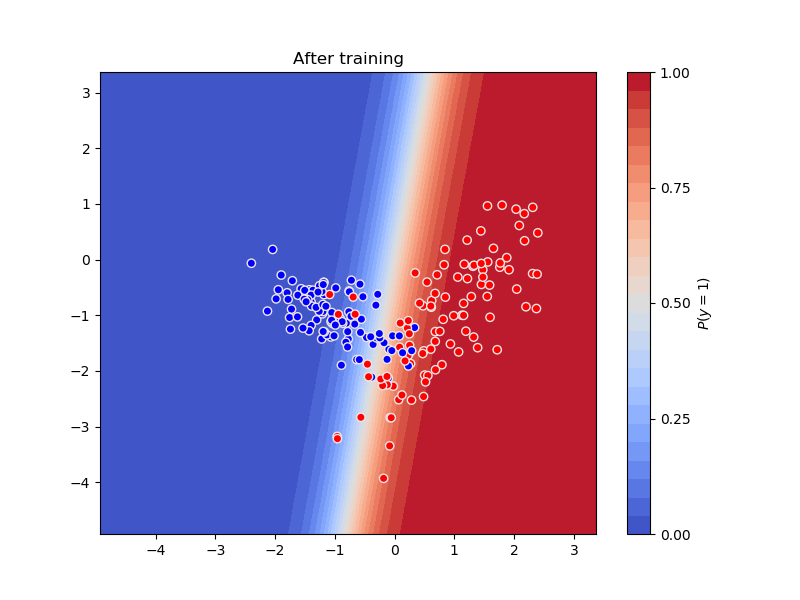

In [21]:
start(X_train,y_train,X_test,y_test,test_thetas,alpha,iteration_count,debug)


### Inner product
Inner product of two vectors, usually written as follows

$$a^Tb$$

In our case it would be

$$\theta^Tx$$

And this is equal to 

$$\theta_1x_1+\theta_2x_2 \ ... \ +\theta_ix_i$$


In [3]:
def inner_product_two_vectors_of_vectors(a,b):
    if a.shape[1]!=b.shape[1]:
        print("shape is not equal (1){}(2){}".format(a.shape[1],b.shape[1]))
    inner_product = np.sum(np.multiply(a,b),axis=1).reshape(-1,1)
    return inner_product

### Exponent 
Here we calculate exponent in power of inner product
$$\pm e^{\mp\theta^Tx}$$

In [4]:
def exp_innerproduct_power(x,thetas,mult):
    result = np.exp(mult*(inner_product_two_vectors_of_vectors(x,thetas)))
    return result

### Hypothesis
Hypothesis of Logistic regression defined as follows
$$h(x) = \frac{1}{1+e^{-\theta^Tx}}\\$$
$$0\leq h(x) \leq 1$$
Hypothesis returns prediction about is the given x is in positive class or in negative class.

$e^{-\theta^Tx}$ goes down when $\theta^Tx$ goes up.

So by modifying $\theta$ we can affect prediction.

In [6]:
# Function that returns an array of [prediction, 1 - prediction]
# needed for future visualization
def hyp_proba(x,thetas):
    predictions = hypothesis(x,thetas)
    pred2d = np.concatenate((predictions,1-predictions),axis=1)
    return pred2d

In [7]:
def hypothesis(x,thetas):
    prediction = 1/(1+exp_innerproduct_power(x,thetas,-1))
    return prediction

### Cost Function

The main task for a cost function is to calculate how well our algorithm performs on train data. Performance measure varies for different algorithm of machine learning. For logistic regression we want to measure how well our fuction predicts the class of out data. So if $y\ =\ 0$ we want $h(x) \rightarrow 0$ or $h(x)\ =\ 0$ and vise versa.

We want when $h(x) \neq y$ increase cost function.

For that reason we could use $\log$. Because $\log_{10}1 = 0 $ and $\log_{10}0.01 = -3$

From statements before we could define our cost function

$$\sum\limits^n_{i=0}-y_i\log_{10}h(x)-(1-y)\log_{10}(1-h(x))$$

This function increases cost when 

$y=0$,but $h(x)\neq0$


$y=1$,but $h(x)\neq1$

In [8]:
def cost_function(x,y,thetas):
    cost = sum(
        np.negative(np.multiply(y,np.log10(hypothesis(x,thetas)+0.0001)))-
        np.multiply((1-y),np.log10(1-hypothesis(x,thetas)+0.00001))
    )
    return cost

### Derivative of cost function
>In order to understand why we want to find the derivative you should firstly look for gradient step section

I think the process of finding the derivative of cost function is beyoung the scoupe of this notebook. If you intrested how to find it you could visit [khan academia](https://www.khanacademy.org/math/differential-calculus). 

Or you could wait for my book of essential ML algorithms to be finished :P 

$$\frac{d}{d\theta_j}\sum\limits^n_{i=0}-y_i\log_{10}h(x)-(1-y)\log_{10}(1-h(x)) = \sum\limits_{i=0}^{n}(y_i(-\frac{x_j}{\ln 10 \cdot (1+e^{\theta^Tx})})+(1-y)\cdot\frac{x_j}{\ln 10 \cdot (1+e^{-\theta^Tx})}$$

>Watch for the subscript of x!

In [9]:
# derivative of log 
# that function exist here only for the simplicity of 
# derivative_of_cost_function function
def derlog(x,theta,ntheta,mult):
    der = mult * (x[:,ntheta].reshape(-1, 1) / (np.log(10) * (1 + exp_innerproduct_power(x,theta,-mult)))).reshape(-1, 1)
    return der 

# this function finds the derivate prior to ntheta
def derivative_of_cost_fuction(x,y,thetas,ntheta):
    change = sum(
        np.multiply(y,derlog(x,thetas,ntheta, -1)) +
        np.multiply(1-y,derlog(x,thetas,ntheta, 1))
    )
    return change

### Gradient Step
In this section we trying to found how we need to change $\theta$ in order to out cost function go down. 
For that reason we calculate the derivative of cost function prior to the theta. Derivative shows us in wich direction we need to go in order to decrease cost function

We need to calculate  new $\theta's$ simultaneously. 

$$\theta_i = \theta_i - \alpha\cdot\frac{d}{d\theta_i} Cost(\theta^Tx)$$

In [10]:
def gradient_step(x,y,thetas,alpha):
    new_thetas=np.array([[]],dtype="f")
    for indx, theta in enumerate(thetas.reshape(-1)):
        new_thetas=np.append(new_thetas,theta-alpha*derivative_of_cost_fuction(x,y,thetas,indx))
    return new_thetas.reshape(1,-1)

### Gradient Descent

Gradient Descent - one of optimization algorithm the ultimate goal of witch - change theta in a way that minimize cost function.

Gradient Descent takes two parameters - iterations (how many steps you will make) and alpha (how far each step will be).
You can see the visualization for deeper understanding.


<IPython.core.display.Javascript object>


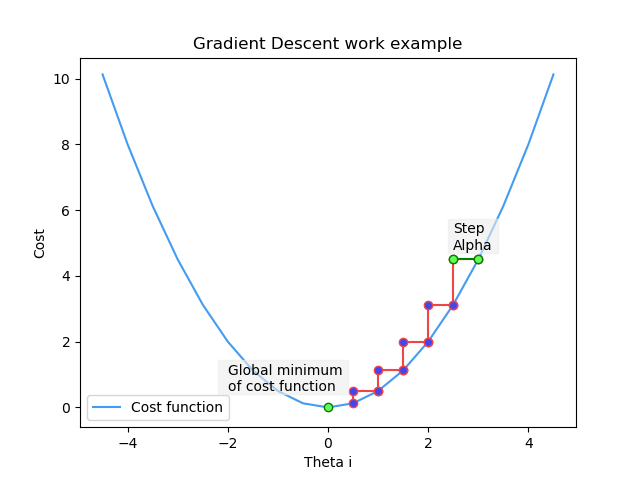

In [11]:
# this code do nothing in the algorithm
# only for overview demonstration of gradient descent
def gradient_descent_visualization():
    import matplotlib.patches as patches
    # that's should'n be changed ^^ 
    alpha = 0.5
    iterations = 5
    def f(x):
        return (1/2)*x**2
    x = np.arange(-4.5,5,0.5).reshape(1,-1)
    y = np.apply_along_axis(f,0,x)
    vis = np.array([[]])
    for i in range(iterations):
        vis = np.append(vis,[x[0,15-i],f(x[0,15-i])])
        vis = np.append(vis,[x[0,15-i]-alpha,f(x[0,15-i])])
        vis = np.append(vis,[x[0,15-i]-alpha,f(x[0,15-i]-alpha)])
    vis = vis.reshape(-1,2)
    fig = plt.figure()
    ax = fig.gca()
    ax.set_title("Gradient Descent work example")
    ax.plot(x[0],y[0],color="#439cef",label="Cost function")
    ax.plot(vis[:,0],vis[:,1],c="#ef4545",marker="o",mfc="#4345ef")
    ax.plot([x[0,15],x[0,15]-alpha],[f(x[0,15]),f(x[0,15])],color="green",marker="o",mfc="#63fc58")
    ax.add_patch(patches.Rectangle((x[0,15]-alpha-0.1,f(x[0,15])+0.19),0.99,1.05,alpha=0.6,color="#EDEDED",zorder=99))
    ax.text(x[0,15]-alpha,f(x[0,15])+0.3,"Step\nAlpha",zorder=100)
    ax.scatter(0,f(0),c="#63fc58",marker="o",edgecolors="green",zorder=100)
    ax.add_patch(patches.Rectangle((-2.2,0.4),2.6,1.05,alpha=0.6,color="#EDEDED",zorder=99))
    ax.text(-2,0.5,"Global minimum\nof cost function",zorder=100)
    ax.set(xlabel="Theta i",ylabel="Cost")
    plt.legend()
    fig.show()
gradient_descent_visualization()

In [19]:
def gradient_descent(x,y,thetas,alpha,iterations):
    for iteration in range(iterations):
        thetas = gradient_step(x,y,thetas,alpha) 
    optimized_thetas = thetas
    return optimized_thetas

### Metric
On this algorithm I will implement only one metric - avg error.

In [12]:
def avg_error_prediction(x,y,thetas):
    predictions=hypothesis(x,thetas)
    accuracy= sum(y-predictions)**2/y.shape[0]
    return accuracy

### Visualization


In [13]:
def visualize(x,y,thetas,alpha,title):
    initial_thetas = thetas
    x1, x2 = np.mgrid[np.min(x)-1:np.amax(x)+1:.1,np.min(x)-1:np.amax(x)+1:.1]
    grid = np.c_[x1.ravel(), x2.ravel()]
    predictions_proba = hyp_proba(grid,thetas)[:,1].reshape(x1.shape)
    fig,ax_m = plt.subplots(figsize=(8, 6))
    contour = ax_m.contourf(x1,x2, predictions_proba, 25, cmap="coolwarm",vmin=0, vmax=1)
    ax_cb = fig.colorbar(contour)
    ax_cb.set_label("$P(y = 1)$")
    ax_cb.set_ticks([0, .25, .5, .75, 1])
    ax_m.scatter(x[:,0],x[:,1],c=-y[:,0],edgecolor="#ede6e6", cmap="bwr", linewidth=1)
    ax_m.set_title(title)
    fig.show()
    return fig, ax_m

#### Debug section

That's debug function that will help you understand what actually are returned by each function.

You can use it by downloading this notebook and changing debug parameter at the setting section

In [14]:
def debugInfo():
    x=np.array([1,12,2,11,3,10,4,9,5,8,6,7,7,6,8,6,9,4,10,3,11,2,12,1]).reshape(-1,2)
    y=np.array([1,1,1,1,1,1,1,0,0,0,0,0]).reshape(-1,1)
    thetas=np.array([5,-8]).reshape(1,2)
    alpha = .1
    iterations=2000
    initial_thetas=thetas
    start_cost_function = cost_function(x,y,thetas)
    print("That will help you understand what each function returns.")
    # ---
    print("X = \n{}".format(x))
    print("Y = \n{}".format(y))
    print("Theta = \n{}".format(thetas))
    # ---
    print("Inner product function: {}".format(inner_product_two_vectors_of_vectors(train_data_X, thetas)))
    print("exp ^ inner product \n{}".format(exp_innerproduct_power(x,thetas,1)))
    print("exp ^-inner product \n{}".format(exp_innerproduct_power(x,thetas,-1)))
    print("hypothesis by initial theta for each x'es \n{}".format(hypothesis(x,thetas)))
    print("Cost of the function by given initial thetas \n{}".format(start_cost_function))
    print("Derivative of cost function priopr to theta_1 \n{}".format(derivative_of_cost_fuction(x,y,thetas,0)))
    print("Derivative of cost function priopr to theta_2 \n{}".format(derivative_of_cost_fuction(x,y,thetas,1)))
    print("Gradient step example\n start thetas\t{}\n after step thetas\t{}".format(
        thetas, gradient_step(x,y,thetas,0.1)
    ))
    thetas= gradient_descent(x,y,thetas,0.1,2000)
    print("New thetas after gradient descent \n{}".format(thetas))
    print("Costs of the function\n{}")
    print("\tOld cost\t{}\n\tNew cost\t{}".format(start_cost_function, cost_function(x,y,thetas)))
    # ---
    visualize(x,y,initial_thetas,alpha)
    visualize(x,y,thetas,alpha)